In [41]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import spacy

In [5]:
data = pd.read_csv('data/jeopardy.csv')
red_data = data.dropna()
red_data.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [6]:
new_cols = {s:s.strip() for s in red_data.columns}
red_data = red_data.rename(columns=new_cols)

In [7]:
# data = data.rename(columns={' Question': 'question', ' Air Date': 'air_date', ' Round':'round'})
red_data['AirDate'] = pd.to_datetime(red_data['Air Date'])
red_data['year'] = pd.DatetimeIndex(red_data['Air Date']).year  # add year feature
red_data.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer,AirDate,year
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,2004-12-31,2004
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,2004-12-31,2004
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,2004-12-31,2004
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,2004-12-31,2004
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,2004-12-31,2004


In [8]:
round_list = red_data['Round'].unique()

In [43]:
j_data = red_data[red_data['Round'] == 'Jeopardy!']
dj_data = red_data[red_data['Round'] == 'Double Jeopardy!']
fj_data = red_data[red_data['Round'] == 'Final Jeopardy!']

In [10]:
years = red_data.year.unique()
years

array([2004, 2010, 2000, 2006, 2009, 1996, 2007, 1997, 2002, 2003, 2001,
       1990, 1999, 2008, 2011, 2005, 1998, 2012, 1992, 1986, 1985, 1991,
       1993, 1994, 1988, 1987, 1995, 1984, 1989])

In [11]:
data_dict = {}
for roun in round_list[:-1]:
    roun_data = red_data[red_data['Round'] == roun]
    for year in years:
        data_dict[f'{roun}-{year}'] = list(red_data.Question.values)

In [12]:
corpus = list(data_dict.values())
new_corpus = [(' ').join(doc) for doc in corpus]

In [73]:
# def plot_top_words(model, feature_names, n_top_words, title):
#     fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
#     axes = axes.flatten()
#     for topic_idx, topic in enumerate(model.components_):
#         top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
#         top_features = [feature_names[i] for i in top_features_ind]
#         weights = topic[top_features_ind]

#         ax = axes[topic_idx]
#         ax.barh(top_features, weights, height=0.7)
#         ax.set_title(f'Topic {topic_idx +1}',
#                      fontdict={'fontsize': 30})
#         ax.invert_yaxis()
#         ax.tick_params(axis='both', which='major', labelsize=20)
#         for i in 'top right left'.split():
#             ax.spines[i].set_visible(False)
#         fig.suptitle(title, fontsize=40)

#     plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
#     plt.show()

def get_top_15(topic_idx, topic, model_components):
    print(model_components[topic_idx][:15])
    return model_components[topic_idx][:15]
    

def plot_top_words(num_topics, X, feature_names, n_top_words, title):
    res = []
    lda = LatentDirichletAllocation(n_components=num_topics, learning_method='online')
    model = lda.fit(X)
    doc_topic_prob = model.transform(X)
    doc_prob = defaultdict(int)
    for row in doc_topic_prob:
        doc_prob[np.argmax(row)] += 1
    total = len(doc_topic_prob)
    row, col = find_largest_divisor(num_topics)
    fig, axes = plt.subplots(row, col, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        print(topic_idx)
        print(len(topic))
        print(model.components_)
        print(len(model.components_))
        top_features_ind = list(get_top_15(topic_idx, topic, model.components_))#topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        prob = 100 * doc_prob[topic_idx]/total
        res.append(prob)
        ax.set_title(f'Topic {topic_idx +1} | {prob:.2f}%',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    return res

# Question 2

In [ ]:
0
2000
[[0.30556295 0.25942952 0.29153162 ... 0.27683033 0.23571636 0.30179932]
 [0.29708698 0.24897822 0.28372713 ... 0.26915914 0.28900112 0.24834243]
 [0.25242491 0.27785853 0.25014418 ... 0.29350256 0.27308811 0.30073165]
 ...
 [0.29489172 0.31276546 0.28554274 ... 0.27565237 0.29887314 0.28123845]
 [0.26293014 0.27720571 0.27205363 ... 0.26793233 0.25145901 0.24909507]
 [0.29481842 0.28835171 0.30672739 ... 0.27818972 0.25773734 0.2596983 ]]
10


KeyError                                  Traceback (most recent call last)
<ipython-input-74-83b3db1ac3d5> in <module>
     21 
     22 
---> 23     odds = plot_top_words(10, X, Vocab, 15, f'LDA on Value: {value}')
     24 
     25     distribution[value] = odds

<ipython-input-73-11befd477c2e> in plot_top_words(num_topics, X, feature_names, n_top_words, title)
     43         print(len(model.components_))
     44         top_features_ind = list(get_top_15(topic_idx, topic, model.components_))#topic.argsort()[:-n_top_words - 1:-1]
---> 45         top_features = [feature_names[i] for i in top_features_ind]
     46         weights = topic[top_features_ind]
     47         ax = axes[topic_idx]

<ipython-input-73-11befd477c2e> in <listcomp>(.0)
     43         print(len(model.components_))
     44         top_features_ind = list(get_top_15(topic_idx, topic, model.components_))#topic.argsort()[:-n_top_words - 1:-1]
---> 45         top_features = [feature_names[i] for i in top_features_ind]
     46         weights = topic[top_features_ind]
     47         ax = axes[topic_idx]

KeyError: 0.2966691227428473

In [29]:
### Preprocessing:
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# jeopardy_df['Text'] = jeopardy_df['Category'] + ' ' + jeopardy_df['Question'] + ' ' + jeopardy_df['Answer']
nlp = spacy.load("en")
nlp.max_length = 3349390

def get_noun_chunks(cell):
    doc = nlp(cell)
    res = []
    for noun in doc.noun_chunks: # use np instead of np.text
        res.append(str(noun))
    return ' '.join(res)

def normalize_text(cell):
    # Remove punctuation:
    cell = cell.lower()
    cell = cell.translate(str.maketrans('', '', string.punctuation))
    wordnet_lemmatizer = WordNetLemmatizer()
    token_list = word_tokenize(cell)
    return ' '.join([wordnet_lemmatizer.lemmatize(w) for w in token_list if w not in stopwords.words('english')])


# jeopardy_df['Text Nouns'] = jeopardy_df['Text'].apply(lambda x: get_noun_chunks(x)) # 13 minutes
# jeopardy_df['Norm Text Nouns'] = jeopardy_df['Text Nouns'].apply(lambda x: normalize_text(x)) # 3 minutes


# corpus = jeopardy_df[jeopardy_df['Year'] == '2001']['Norm Text Nouns'].values
# vectorizer = TfidfVectorizer(stop_words={'english'})#, max_df=0.8)
# X = vectorizer.fit_transform(corpus)

## Jeopardy questions grouped by question value

In [75]:
# These are the possible values for jeopardy questions (excluding daily doubles)
poss_values = ['$200', '$400', '$600', '$800', '$1000',  '$400', '$800', '$1200', '$1600', '$2000']

In [18]:
j_data.Value.unique()

array(['$200', '$400', '$600', '$800', '$2,000', '$1000', '$100', '$300',
       '$500', '$1,200', '$2,200', '$3,000', '$1,500', '$1,600', '$1,800',
       '$1,000', '$1,400', '$700', '$4,800', '$2,500', '$1,300', '$900',
       '$3,600', '$3,200', '$2,800', '$1,100', '$5,000', '$3,389',
       '$5,600', '$3,800', '$5', '$2,600', '$2,300', '$1,263', '$2,400',
       '$6,600', '$4,200', '$2,700', '$350', '$3,400', '$4,000', '$1,700',
       '$250', '$3,989', '$2,100', '$750', '$1,900', '$3,100', '$5,200',
       '$3,500', '$4,600', '$796', '$6,000', '$2,900'], dtype=object)

In [19]:
j_data = j_data[j_data['Value'].isin(poss_values)]

In [ ]:
# j_data_val = j_data.groupby(by=['Value', 'Category']).agg({'Question': lambda x: ' '.join(x),
#                                                            'Answer': lambda x: ' '.join(x)})

In [21]:
j_data_val = j_data.groupby(by=['Value']).agg({'Category': lambda x: ' '.join(x),
                                               'Question': lambda x: ' '.join(x),
                                               'Answer': lambda x: ' '.join(x)})

In [22]:
j_data_val.head()

,Category,Question,Answer
Value,,,
$1000,HISTORY ESPN's TOP 10 ALL-TIME ATHLETES THE CO...,This Asian political party was founded in 1885...,the Congress Party (Wilt) Chamberlain K2 Ethan...
$200,HISTORY ESPN's TOP 10 ALL-TIME ATHLETES EVERYB...,"For the last 8 years of his life, Galileo was ...",Copernicus Jim Thorpe Arizona McDonald's John ...
$400,HISTORY ESPN's TOP 10 ALL-TIME ATHLETES EVERYB...,Built in 312 B.C. to link Rome & the South of ...,the Appian Way Michael Jordan Washington Crate...
$600,HISTORY ESPN's TOP 10 ALL-TIME ATHLETES EVERYB...,In 1000 Rajaraja I of the Cholas battled to ta...,Ceylon (or Sri Lanka) Jim Brown the UV index B...
$800,HISTORY ESPN's TOP 10 ALL-TIME ATHLETES EVERYB...,Karl led the first of these Marxist organizati...,the International (Lou) Gehrig Morocco (Paul) ...


In [23]:
j_data_val['Text'] = j_data_val.Category + ' ' + j_data_val.Question + ' ' + j_data_val.Answer

In [24]:
# def normalize_text(cell):
#     # Remove punctuation:
#     cell = cell.lower()
#     cell = cell.translate(str.maketrans('', '', string.punctuation))
#     nlp = spacy.load('en')
#     nlp.max_length = 1500000
#     cell = nlp(cell).noun_chunks
#     wordnet_lemmatizer = WordNetLemmatizer()
#     token_list = word_tokenize((' ').join(cell))
    
#     return ' '.join([wordnet_lemmatizer.lemmatize(w) for w in token_list if w not in stopwords.words('english')])

In [30]:
j_data_val['Text Nouns'] = j_data_val['Text'].apply(lambda x: get_noun_chunks(x)) # 13 minutes
j_data_val['Norm Text Nouns'] = j_data_val['Text Nouns'].apply(lambda x: normalize_text(x)) # 3 minutes

In [ ]:
# j_data_val['Norm_Doc'] = j_data_val['Document'].apply(lambda x: normalize_text(x))

In [ ]:
j_data_val.shape

In [ ]:
# corpus = jeopardy_df[jeopardy_df['Year'] == '2001']['Norm Text Nouns'].values

In [31]:
corpus = [text.lower() for text in j_data_val['Norm Text Nouns'].values]
# corpus = jeopardy_df[jeopardy_df['Year'] == '2001']['Norm Text Nouns'].values

vectorizer = TfidfVectorizer(stop_words={'english'})#, max_df=0.8)
X = vectorizer.fit_transform(corpus)

In [ ]:
# vectorizer = TfidfVectorizer(stop_words={'english'}, max_df=0.8)
# X = vectorizer.fit_transform(corpus)

In [32]:
Vocab = {index:word for index, word in enumerate(vectorizer.get_feature_names())}

In [33]:
NUM_TOPICS = 15

In [34]:
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, learning_method='online')

In [35]:
lda.fit(X)

/Users/kylebrooks/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:806: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)


LatentDirichletAllocation(learning_method='online', n_components=15)

In [36]:
word_topic = lda.components_

In [37]:
lda.transform(X).shape

(5, 15)

In [38]:
from collections import defaultdict
topics = defaultdict(list)
for t in range(NUM_TOPICS):
    # val > 0.5 -> it's part of the topic
    for index, val in enumerate(word_topic[t].argsort()[-15:-1]):#[0,:]):
        topics[t].append(Vocab[val])

In [39]:
topics

defaultdict(list,
            {0: ['oomf',
              'triolas',
              'acedeuce',
              'mayhem',
              'baloo',
              'dubhe',
              'benatar',
              'lallemande',
              'questionanswer',
              'downward',
              'emolument',
              'media20050518j03ajpg',
              'blemish',
              'prussia'],
             1: ['conversationalist',
              'hrefhttpwwwjarchivecommedia20100719j24ajpg',
              'amphissa',
              'choroid',
              'hrefhttpwwwjarchivecommedia20111115j05wmvplantinga',
              'capsule',
              'erharts',
              'coruler',
              'heavn',
              'tienes',
              'carolus',
              'piccolo',
              'bedin',
              'snead'],
             2: ['american',
              'man',
              'type',
              'time',
              'one',
              'clue',
              'world',
             

In [48]:
j_data_val.index

Index(['$1000', '$200', '$400', '$600', '$800'], dtype='object', name='Value')

0
2000
[[0.29666912 0.2707391  0.28058192 ... 0.28867727 0.28379061 0.28667501]
 [0.33950569 0.26238346 0.28499491 ... 0.31381439 0.28223633 0.2805016 ]
 [0.28117632 0.25072089 0.25335013 ... 0.27843626 0.26654116 0.2770392 ]
 ...
 [0.26589055 0.28230254 0.27872306 ... 0.26352411 0.25729489 0.26275545]
 [0.26968404 0.27689706 0.26348442 ... 0.26654505 0.31218513 0.28686979]
 [0.26842011 0.27009231 0.28363626 ... 0.28689753 0.24972654 0.29610783]]
10
[0.29666912 0.2707391  0.28058192 0.26609152 0.29484894 0.29071109
 0.2679164  0.27111025 0.30736071 0.30748643 0.30336894 0.25311884
 0.26101155 0.25987406 0.29731905]


KeyError: 0.2966691227428473

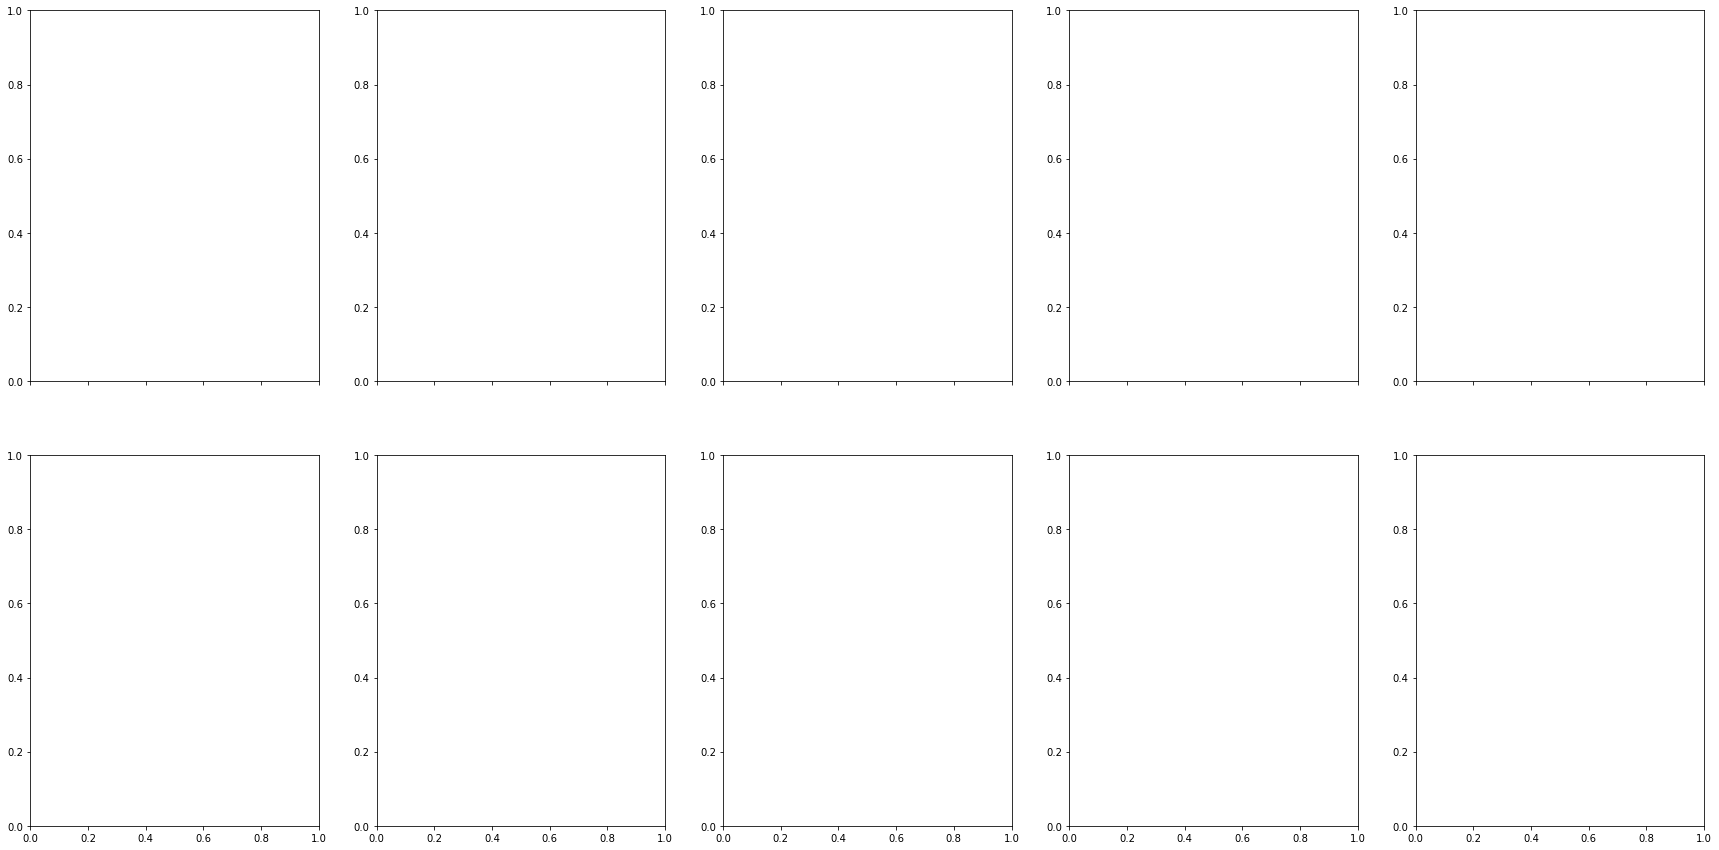

In [74]:
def find_largest_divisor(num):
    res = []
    for i in range(1, num):
        if is_integer(num/i):
            res.append(i)
    return res[len(res)//2], num//res[len(res)//2]

def is_integer(num):
    return num.is_integer()

topics = defaultdict(list)
distribution = defaultdict(list)
for value in np.unique(j_data_val.index):
#     corpus = j_data_val[j_data_val['Value'] == value]['Norm Text Nouns'].values
    corpus = j_data_val[j_data_val.index == value]['Norm Text Nouns'].values
    
    vectorizer = TfidfVectorizer(stop_words={'english'}, ngram_range=(1,5), max_features=2000)
    X = vectorizer.fit_transform(corpus)
    Vocab = {index:word for index, word in enumerate(vectorizer.get_feature_names())}
    
    
    
    odds = plot_top_words(10, X, Vocab, 15, f'LDA on Value: {value}')
    
    distribution[value] = odds
    
    for i in range(10):
        topic = input(f'What topic is topic {i+1}?')
        topics[value].append(topic)

In [ ]:
# tfidf_feature_names = vectorizer.get_feature_names()
# plot_top_words(lda, tfidf_feature_names, 10,
#                'Topics in LDA model')

## Double Jeopardy questions grouped by question value

In [ ]:
dj_data.Value.unique()

In [ ]:
dj_values = ['$400', '$800', '$1200', '$1500', '$2000']

In [ ]:
dj_data = dj_data[dj_data['Value'].isin(dj_values)]

In [ ]:
dj_data_val = dj_data.groupby(by=['Value']).agg({'Category': lambda x: ' '.join(x),
                                               'Question': lambda x: ' '.join(x),
                                               'Answer': lambda x: ' '.join(x)})

In [ ]:
dj_data_val['Document'] = dj_data_val.Category + ' ' + dj_data_val.Question + ' ' + dj_data_val.Answer

In [ ]:
dj_data_val['Norm_Doc'] = dj_data_val['Document'].apply(lambda x: normalize_text(x))

In [ ]:
corpus = [text.lower() for text in dj_data_val['Norm_Doc'].values]

In [ ]:
vectorizer = TfidfVectorizer(stop_words={'english'}, max_df=0.8)
X = vectorizer.fit_transform(corpus)

Vocab = {index:word for index, word in enumerate(vectorizer.get_feature_names())}

In [ ]:
NUM_TOPICS = 5
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, learning_method='online')

In [ ]:
lda.fit(X)
word_topic = lda.components_

In [ ]:
from collections import defaultdict
topics = defaultdict(list)
for t in range(NUM_TOPICS):
    # val > 0.5 -> it's part of the topic
    for index, val in enumerate(word_topic[t].argsort()[-15:-1]):#[0,:]):
        topics[t].append(Vocab[val])

In [ ]:
topics

In [ ]:
# tfidf_feature_names = vectorizer.get_feature_names()
# plot_top_words(lda, tfidf_feature_names, 10,
#                'Topics in LDA model')